# 1. 导入python库

In [1]:
import pandas as pd
import numpy as np
import os

%matplotlib inline
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout

from tensorflow.keras.utils import plot_model

from sklearn.metrics import confusion_matrix, roc_curve, auc, recall_score, precision_score, f1_score


# 2. 参数设置

In [2]:
daily_back=20
wenben_back=10

wenben_sort=2

batch_size=8
epochs=100

LSTM_num=100
dense_num=20


mix_file='daily_data.xlsx'
first_columns='search_index'


total_day=2159 #根据查看数据表，得到数值
train_num=1727
test_num=total_day-train_num

# 3. 读取原始数据

In [3]:
new_dir='/Users/ccmac/Desktop/完成SCI数据'


daily_df=pd.read_excel(os.path.join(new_dir,mix_file))
fif_df=pd.read_excel(os.path.join(new_dir,'fif_data.xlsx'))
target_df=pd.read_excel(os.path.join(new_dir,'target.xlsx'))
wenben_df=pd.read_excel(os.path.join(new_dir,mix_file))

# 4. 标准化

## 4.1 历史数据标准化函数norm

In [4]:
def norm(df):
    x=df.copy()
    open_mean_value = df['open'].mean(axis=0)
    high_mean_value = df['high'].mean(axis=0)
    low_mean_value = df['low'].mean()
    close_mean_value = df['close'].mean()
    volumerate_mean_value = df['volume_rate'].mean()

    open_std_value = df['open'].std()
    high_std_value = df['high'].std()
    low_std_value = df['low'].std()
    close_std_value = df['close'].std()
    volumerate_std_value = df['volume_rate'].std()

    x['open']=(df['open']-open_mean_value)/open_std_value
    x['high'] = (df['high'] - high_mean_value) / high_std_value
    x['low'] =  (df['low'] - low_mean_value) / low_std_value
    x['close'] =  (df['close'] - close_mean_value) / close_std_value
    x['volume_rate'] = (df['volume_rate'] - volumerate_mean_value) / volumerate_std_value
    df=x
    return df

## 4.2 文本数据标准化函数wenben_norm

In [5]:
def wenben_norm(df):
    x=df.copy()
    sector_score_mean_value = df['sector_score'].mean(axis=0)
    search_index_mean_value = df['search_index'].mean(axis=0)

    sector_score_std_value = df['sector_score'].std()
    search_index_std_value = df['search_index'].std()

    x['sector_score']=(df['sector_score']-sector_score_mean_value)/sector_score_std_value
    x['search_index'] = (df['search_index'] - search_index_mean_value) / search_index_std_value
    
    df=x
    
    return df

# 5. 数据切分训练集与测试集

## 5.1 数据切分函数

In [6]:
def split_data(train_num=train_num,wenben_back=wenben_back):
    daily_train_df=daily_df.loc[daily_df.index<train_num]
    daily_test_df=daily_df.loc[daily_df.index>=train_num]
    fif_train_df=fif_df.loc[fif_df.index<16*train_num]
    fif_test_df=fif_df.loc[fif_df.index>=16*train_num]
    wenben_train_df=wenben_df.loc[wenben_df.index<train_num]
    wenben_test_df=wenben_df.loc[wenben_df.index>=train_num]

    target_train_df=target_df.loc[target_df.index<train_num]
    target_test_df=target_df.loc[target_df.index>=train_num]

    daily_train_df=norm(daily_train_df)
    daily_test_df=norm(daily_test_df)
    fif_train_df=norm(fif_train_df)
    fif_test_df=norm(fif_test_df)
    wenben_train_df=wenben_norm(wenben_train_df)
    wenben_test_df = wenben_norm(wenben_test_df)


    return {'daily_train_df':daily_train_df,
            'daily_test_df':daily_test_df,
            'fif_train_df':fif_train_df,
            'fif_test_df':fif_test_df,
            'target_train_df':target_train_df,
            'target_test_df':target_test_df,
            'wenben_train_df':wenben_train_df,
            'wenben_test_df': wenben_test_df
            }

## 5.2 进行数据切分

In [7]:
daily_train_df=split_data()['daily_train_df']
print('日频训练切分：',daily_train_df.shape)
daily_test_df=split_data()['daily_test_df']
print('日频测试切分：',daily_test_df.shape)
fif_train_df=split_data()['fif_train_df']
print('十五分钟频训练切分：',fif_train_df.shape)
fif_test_df=split_data()['fif_test_df']
print('十五分钟频测试切分：',fif_test_df.shape)
target_train_df=split_data()['target_train_df']
print('训练目标切分：',target_train_df.shape)
target_test_df=split_data()['target_test_df']
print('测试目标切分：',target_test_df.shape)
wenben_norm_train_df=split_data()['wenben_train_df']
wenben_norm_test_df=split_data()['wenben_test_df']

日频训练切分： (1727, 8)
日频测试切分： (432, 8)
十五分钟频训练切分： (27632, 6)
十五分钟频测试切分： (7088, 6)
训练目标切分： (1727, 2)
测试目标切分： (443, 2)


# 6. 数据转化为神经网络输入格式

## 6.1 建立转化类（返回多个字典）

In [8]:
class Data_maker:
    def __init__(self,train_num,test_num,fif_back,daily_back,wenben_back):
        self.train_num=train_num
        self.test_num=test_num
        self.fif_back=fif_back
        self.daily_back=daily_back
        self.wenben_back = wenben_back


    def daily_train_data(self,data):
        while True:
            rows = list(range(self.train_num - self.daily_back)) #总共1650个数据，由于扣除前面20个数据，所以为1630
            ### 先构造空（预测日长度*日后移）array
            samples = np.zeros((len(rows),
                                 self.daily_back,
                                 5))
            print(samples.shape)
            for j in rows:
                ### 每一个填入用于预测一天的开盘价到波动率矩阵
                samples[j] = data.loc[
                                  (data.index >= j) & (data.index < self.daily_back + j),
                                  'open':'volume_rate']
            print(data.index)
            print('日频训练array：',samples.shape)
            return samples
    def fif_train_data(self,data):
        while True:
            rows = list(range(self.train_num - self.daily_back))
            samples = np.zeros((len(rows),
                                 self.fif_back,
                                 5))
            for j in rows:

                samples[j] = data.loc[
                              (data.index >= j * self.fif_back ) & (data.index < (j+1) * self.fif_back),
                              'open':]
            print('十五分钟训练array：',samples.shape)
            return samples
    def wenben_train_data(self,data):
        while True:
            rows = list(range(self.train_num - self.daily_back)) #总共1489个数据，由于扣除前面20个数据，所以为1469
            samples = np.zeros((len(rows),
                                 self.wenben_back,
                                 wenben_sort))
            for j in rows:

                samples[j] = data.loc[
                                  (data.index >= j) & (data.index < self.wenben_back + j),
                                  first_columns:]
            print('文本长期训练array：',samples.shape)
            return samples
   

    def daily_test_data(self,data):
        while True:
            rows = list(range(self.test_num - self.daily_back))
            print(self.test_num,self.daily_back)
            print(rows)
            samples = np.zeros((len(rows),
                                self.daily_back,
                                 5))
            for j in rows:


                samples[j] = data.loc[
                                  (data.index >= self.train_num+j) & (data.index < self.train_num+self.daily_back + j),
                                  'open':'volume_rate']
            print('日测试array：',samples.shape)
            print('试一试index', data.index,'train_num',self.train_num)
            return samples

    def wenben_test_data(self, data):
        while True:
            rows = list(range(self.test_num - self.daily_back))
            samples = np.zeros((len(rows),
                                self.wenben_back,
                                wenben_sort))
            for j in rows:
                samples[j] = data.loc[
                             (data.index >= self.train_num + j) & (data.index < self.train_num + self.wenben_back + j),
                             first_columns:]
            print('长期文本测试array：', samples.shape)
            return samples
   
    def fif_test_data(self,data):
        while True:
            rows = list(range(self.test_num - self.daily_back))
            samples = np.zeros((len(rows),
                                self.fif_back,
                                 5))
            for j in rows:


                samples[j] = data.loc[
                                 (data.index >= 16*self.train_num+(j) * self.fif_back) & (data.index < 16*self.train_num+(j+1) * self.fif_back),
                                 'open':]
            print('十五分钟测试array：',samples.shape)
            return samples
    def target_train_data(self,data):
        while True:
            rows = list(range(self.train_num-self.daily_back))
            targets = np.zeros((len(rows),))
            for j in rows:


                targets[j] = data.loc[data.index == j, 'target'].iloc[0] #根据提示，添加了.iloc[0]
            print('训练标签array',targets.shape)
            return targets
    def target_test_data(self,data):
        while True:
            rows = list(range(self.test_num-self.daily_back))
            targets = np.zeros((len(rows),))
            for j in rows:


                targets[j] = data.loc[data.index == self.train_num+j, 'target'].iloc[0] ##出问题：应该是。而不是***：data.index == self.train_num+j
            print(targets.shape)
            return targets

## 6.2 设置类方法里的参数，赋值给origin_data_maker，仍然是一个class类

In [9]:
origin_data_maker=Data_maker(train_num=train_num,test_num=test_num,fif_back=16,daily_back=20,wenben_back=wenben_back)

# 6.3 调用类中的方法,处理原始数据

In [10]:
DM=origin_data_maker

daily_train=DM.daily_train_data(daily_train_df)
daily_test=DM.daily_test_data(daily_test_df)
fif_train=DM.fif_train_data(fif_train_df)
fif_test=DM.fif_test_data(fif_test_df)
target_train=DM.target_train_data(target_train_df)
target_test=DM.target_test_data(target_test_df)

wenben_train=DM.wenben_train_data(wenben_norm_train_df)

wenben_test=DM.wenben_test_data(wenben_norm_test_df)


(1707, 20, 5)
Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726],
      dtype='int64', length=1727)
日频训练array： (1707, 20, 5)
432 20
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176

# 7. 神经网络模型训练

## 7.1 模型建立 

In [11]:
def my_model():

    # 假设的参数
    LSTM_num = 32
    dense_num = 64

    model = Sequential()
    # 使用 Input 层指定输入形状
    model.add(Input(shape=(20, 5)))
    model.add(Conv1D(16, 1, strides=1))
    model.add(LSTM(LSTM_num))
    model.add(Dense(dense_num, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.summary()
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['acc'])
    return model
   


## 7.2 模型滞后时长赋值

In [12]:
model=my_model()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20, 16)         │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,545 (33.38 KB)

 Trainable params: 8,545 (33.38 KB)

 Non-trainable params: 0 (0.00 B)

## 7.3 添加输出模型参数的代码块

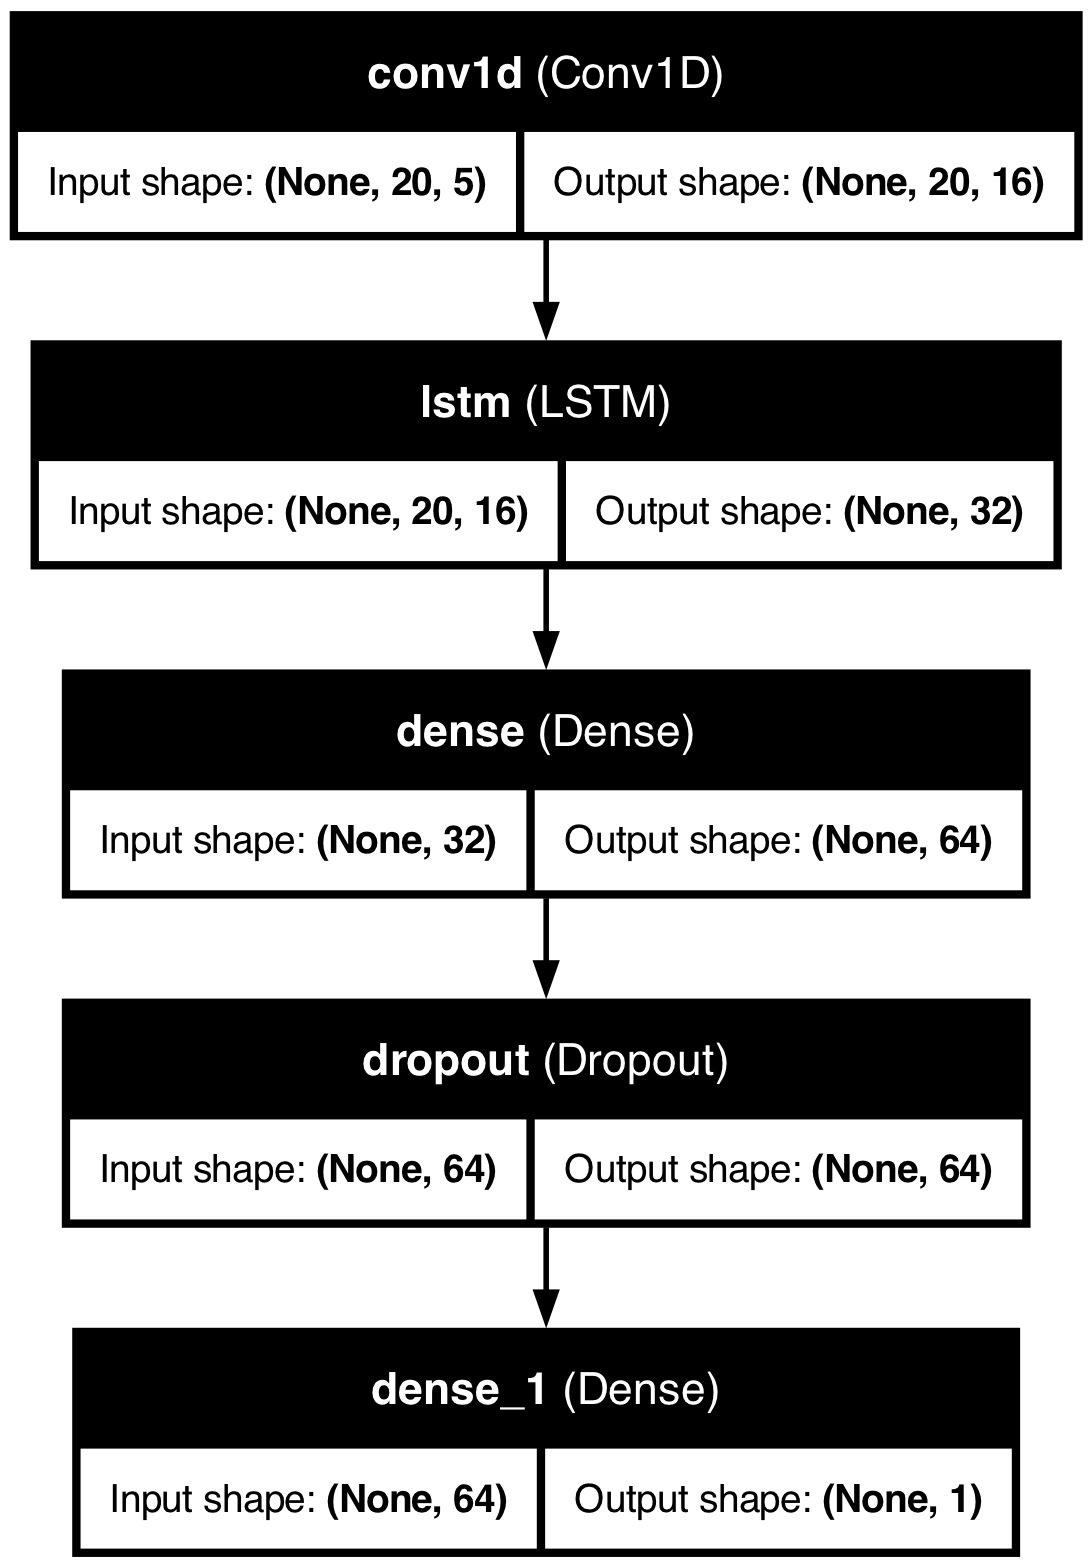

In [13]:
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

## 7.4 model.fit(输入训练数据x，标志y)

In [14]:
history = model.fit(x=daily_train,y=target_train,batch_size=batch_size,validation_split=0.25,epochs=epochs)


Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.5404 - loss: 0.6946 - val_acc: 0.5012 - val_loss: 0.7025
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.5854 - loss: 0.6873 - val_acc: 0.5012 - val_loss: 0.7154
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.5459 - loss: 0.6918 - val_acc: 0.5012 - val_loss: 0.7108
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.5663 - loss: 0.6820 - val_acc: 0.5012 - val_loss: 0.7054
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.5630 - loss: 0.6853 - val_acc: 0.5012 - val_loss: 0.7060
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.5378 - loss: 0.6845 - val_acc: 0.5012 - val_loss: 0.7038
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.5743 - loss: 0.6830 - val_acc: 0.5012 - val_loss: 0.7074
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.5857 - loss: 0.6785 - val_acc: 0.5012 - val_loss: 0.7072
Epoch 9/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

## 7.5 model.evaluate(输入测试数据)，进行模型预测性能测试

In [15]:
loss,accuracy = model.evaluate(daily_test,y=target_test)
print(loss,accuracy)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.4974 - loss: 0.9544 
0.9543619751930237 0.4927184581756592


# 8. 回测

# 构建y的函数

In [16]:
def gen_y_pred():
    y_predict=model.predict(daily_test,batch_size=1).reshape(test_num-daily_back).tolist() ###batch_size要设为1，不然evaluate和predict结果不同
    y_pred=[]
    for i,v in enumerate(y_predict):
        if v>0.5:
            y_pred.append(1)
        if v<0.5:
            y_pred.append(0)
    return y_pred

# 制作y

In [17]:
y_pred=gen_y_pred()
print(y_pred)

412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,

#  构建使用测试集作为回测数据的类

In [18]:
class Back_tes_trader:
    def __init__(self,train_num,daily_back,wenben_back):
        self.train_num=train_num
        self.daily_back=daily_back
        self.wenben_back = wenben_back
    def daily_test_data(self,data):
        while True:
            samples = data.loc[
                data.index >=self.train_num+self.wenben_back ,
                ['open','close']]
            print(data.index)
            return samples
        


# 回测数据集代入参数，形成回撤数据back_tes_trader

In [19]:
back_tes_trader=Back_tes_trader(train_num=train_num,daily_back=20,wenben_back=daily_back)

In [20]:
def split_back_trader(train_num=train_num):

    daily_test_df=daily_df.loc[daily_df.index>=train_num]

    return {'daily_test_df':daily_test_df}

In [21]:
back_df=split_back_trader()['daily_test_df']

In [22]:
back_df

,trade_time,open,high,low,close,volume_rate,search_index,sector_score
1727,2023-02-28,3265.74,3280.42,3246.14,3279.61,251625032,176171,-0.807574
1728,2023-03-01,3279.14,3315.16,3272.04,3312.35,318398704,182940,-0.593634
1729,2023-03-02,3308.01,3320.74,3306.46,3310.65,328520016,182444,-0.801063
1730,2023-03-03,3314.77,3330.60,3302.62,3328.39,343996919,173078,-0.761493
1731,2023-03-06,3332.02,3333.06,3308.73,3322.03,340530446,174705,-0.720088
...,...,...,...,...,...,...,...,...
2154,2024-12-02,3328.48,3369.30,3323.01,3363.98,668477762,428407,-0.647137
2155,2024-12-03,3366.29,3386.62,3348.37,3378.81,663030139,438283,-0.861024
2156,2024-12-04,3376.57,3388.02,3352.94,3364.65,621028862,425902,-0.984183
2157,2024-12-05,3353.06,3377.06,3353.06,3368.86,543885746,397751,-0.812990


In [23]:
backtrader_df=back_tes_trader.daily_test_data(back_df)

Index([1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734, 1735, 1736,
       ...
       2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158],
      dtype='int64', length=432)


# 形成day_rate_of_return日内收益率，和rate_of_return隔夜收益率

In [24]:
backtrader_df['rate_of_return'] = backtrader_df['close'].rolling(2).apply(lambda x: x[1] / x[0] - 1, raw=True)
backtrader_df['day_rate_of_return']=backtrader_df['close']/backtrader_df['open']-1

clo_1=backtrader_df.loc[(backtrader_df.index<total_day-1),"close"].tolist()

print(len(clo_1))
print(backtrader_df.loc[(backtrader_df.index>=train_num+20+1),:])
backtrader_df.loc[(backtrader_df.index>=train_num+20+1),'last_close']=clo_1
backtrader_df['sale_rate_of_return']=backtrader_df['open']/backtrader_df['last_close']-1


print(backtrader_df)
print(backtrader_df.shape)
trade_day_return_list=[]
return_list=[]
every_day_return_list=[]

411
         open    close  rate_of_return  day_rate_of_return
1748  3253.62  3240.06       -0.001639           -0.004168
1749  3243.07  3261.25        0.006540            0.005606
1750  3263.41  3272.86        0.003560            0.002896
1751  3277.34  3296.40        0.007192            0.005816
1752  3297.18  3312.56        0.004902            0.004665
...       ...      ...             ...                 ...
2154  3328.48  3363.98        0.011279            0.010666
2155  3366.29  3378.81        0.004408            0.003719
2156  3376.57  3364.65       -0.004191           -0.003530
2157  3353.06  3368.86        0.001251            0.004712
2158  3370.94  3404.08        0.010455            0.009831

[411 rows x 4 columns]
         open    close  rate_of_return  day_rate_of_return  last_close  \
1747  3256.60  3245.38             NaN           -0.003445         NaN   
1748  3253.62  3240.06       -0.001639           -0.004168     3245.38   
1749  3243.07  3261.25        0.006540    

# 回测交易逻辑

In [25]:
def backtrader(list,df):
    a=0

    rate_of_return = 1
    for i,v in enumerate(list):
        if (v ==1)&(a==0):
            b=(1 + df.loc[train_num+20 + i, 'day_rate_of_return'])
            rate_of_return= rate_of_return * b
            a=1
            trade_day_return_list.append(b-1)
            return_list.append(rate_of_return)
            every_day_return_list.append(b - 1)

        elif (v ==1)&(a==1):
            b=(1 + df.loc[train_num+20 + i, 'rate_of_return'])
            rate_of_return= rate_of_return *b
            a=a
            trade_day_return_list.append(b-1)
            return_list.append(rate_of_return)
            every_day_return_list.append(b - 1)
        elif (v==0)&(a==0):
            rate_of_return=rate_of_return
            a=a
            every_day_return_list.append(0)

        elif (v==0)&(a==1):
            a=0
            b = (1 + df.loc[train_num+20 + i, 'sale_rate_of_return'])
            rate_of_return=rate_of_return*b
            trade_day_return_list.append(b-1)
            every_day_return_list.append(b - 1)
            return_list.append(rate_of_return)
    return a,trade_day_return_list,rate_of_return,return_list,every_day_return_list

In [26]:
result=backtrader(y_pred,backtrader_df)
print(result[1])
print(result[2])
print(result[3])
pingjun_nian_jiaoyi_ri=240*len(result[1])/(len(y_pred))
sharp=(np.mean(result[1]))/(np.std(result[1],ddof=1))*np.sqrt(pingjun_nian_jiaoyi_ri)
# sharp1=(np.mean(result[4]))/(np.std(result[4]))
# print('夏普比率--：',sharp1)
print('夏普比率：',sharp)
print('收益率：',result[2]-1)


[-0.003445311060615297, -0.0016392533385921615, 0.006540002345635676, 0.003559984668455307, 0.0071924860825087755, 0.00023662176920269395, 0.0031113764222787665, -0.002650893549492328, 0.005963789341723036, 0.01421745577640321, 0.002280239011581253, -0.006836941883046954, -0.0009198458219712435, -0.019533535489734244, -0.007830343565790154, -0.0032179177568609774, -0.00023584399991427585, 0.006672589687815922, 0.011378991320437626, 0.008181700553972382, -0.0047635250085062975, 0.0019463187884238842, -0.0057912608453972725, -0.0020540931452237565, 0.0039857135462497695, -0.004179151553382776, 0.0039378232030065075, -0.015237511641240431, -0.012780940411060149, -0.001089008503003308, 0.0035111174974853387, 0.0027859922178987695, 0.0008567570503965616, -0.006094516176055609, 2.1843872481719373e-05, 0.007938513962610472, 0.0007337302287566683, -0.0012467362116543868, -0.009971796626121132, -0.014784702460990062, 0.01232138436244301, -0.0018655312531353774, 0.007279201741472008, 0.013091572

In [27]:
returns=result[3]
returns = [ret - 1 for ret in returns]
returns

[-0.003445311060615297,
 -0.005078916661548805,
 0.0014278695572069733,
 0.004992937419394439,
 0.012221335134803057,
 0.012460848737947394,
 0.015610995551190943,
 0.01291871891429075,
 0.018959552774183486,
 0.03344656515369393,
 0.035803070327941944,
 0.028721344933828163,
 0.027775079902718103,
 0.007698998903973964,
 -0.000191630468346915,
 -0.0034089315741210324,
 -0.003643971597977469,
 0.003004303362531102,
 0.014417480624854928,
 0.022717140688042647,
 0.017845402011747113,
 0.01982645364139346,
 0.013920372631319733,
 0.011837685744094939,
 0.015870580914771226,
 0.011625103798505343,
 0.015608704604986867,
 0.00013335514562329287,
 -0.012649289669606545,
 -0.013724522988602716,
 -0.010261593903927335,
 -0.00750419040678818,
 -0.006653862624430129,
 -0.012707826727087923,
 -0.012686260442752784,
 -0.0048484565358004605,
 -0.004118283766166964,
 -0.00535988556432021,
 -0.015278234501654664,
 -0.029837052811408582,
 -0.017883302244897425,
 -0.01971547163878573,
 -0.012579782792

In [28]:
returns=result[3]
returns = [ret - 1 for ret in returns]

# 将收益率列表转换为pandas的Series对象，方便处理
returns_series = pd.Series(returns)

# 计算累计收益率
cumulative_returns = (1 + returns_series).cumprod() - 1

# 计算滚动最大值
rolling_max = cumulative_returns.cummax()

# 计算回撤
drawdown = cumulative_returns - rolling_max

# 计算最大回撤
max_drawdown = drawdown.min()

# 打印最大回撤
print("最大回撤: {:.2%}".format(max_drawdown))


最大回撤: -125.09%


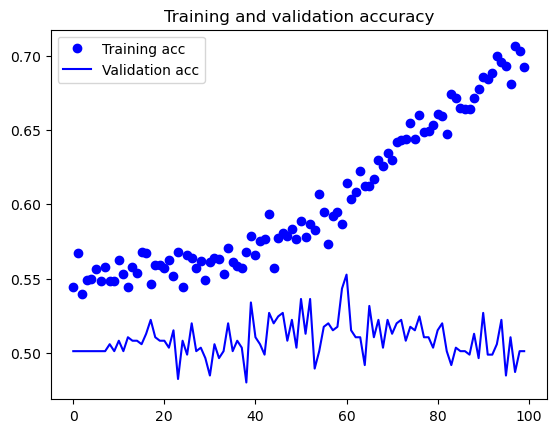

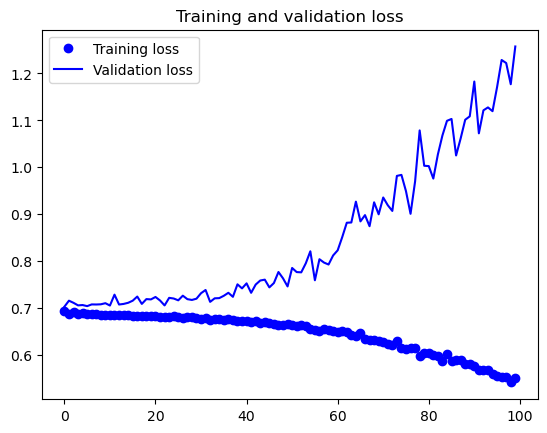

In [29]:
def paint():
    acc=history.history['acc']
    val_acc=history.history['val_acc']
    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs=range(len(acc))
    plt.plot(epochs,acc,'bo',label='Training acc')
    plt.plot(epochs,val_acc,'b',label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs,loss,'bo',label='Training loss')
    plt.plot(epochs,val_loss,'b',label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    return plt
my_paint=paint()
my_paint.show()

# 混淆矩阵绘制

In [30]:
confusion_matrix = confusion_matrix(target_test, y_pred,labels=[1,0])
precision_score=precision_score(target_test, y_pred)
recall_score=recall_score(target_test, y_pred)
f1_score=f1_score(target_test, y_pred)

print('混淆矩阵：',confusion_matrix)
print('查准率：',precision_score)
print('查全率：',recall_score)
print('f1-score:',f1_score)

混淆矩阵： [[114  87]
 [122  89]]
查准率： 0.4830508474576271
查全率： 0.5671641791044776
f1-score: 0.5217391304347826


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


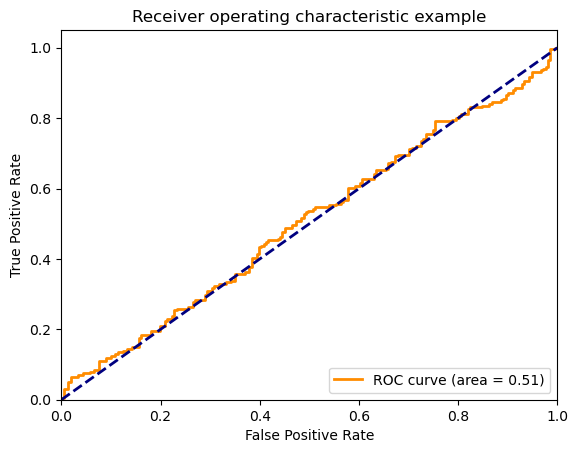

In [31]:
y_predict=model.predict(daily_test).reshape(test_num-daily_back).tolist()
fpr,tpr,threshold = roc_curve(target_test, y_predict) ###计算真正率和假正率
# print(fpr,tpr,threshold)
roc_auc = auc(fpr,tpr)


lw = 2
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# 保存

In [32]:
# df9=pd.DataFrame({'损失值':loss,'准确率':accuracy,'夏普值':sharp,'收益率':result[2]-1,'最大回撤':[max_drawdown],'查准率':[precision_score],'查全率':[recall_score],'f1-score':[f1_score]})
# df10=pd.DataFrame({'每日收益率':result[1]})
# path9='/Users/ccmac/Desktop'
# df9.to_excel(os.path.join(path9,'数据表.xlsx'),index=False)
# df10.to_excel(os.path.join(path9,'每日收益率表.xlsx'),index=False)

In [33]:
# import numpy as np
# t = np.array([1, 2, 3, 4, 5, 6, 7, 8]).reshape([2,4])
# y = np.cumprod(t, axis=1)
# print(t)
# print(y)
